# Analysis of Patterns Learned By SSL

In [12]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [13]:
%matplotlib inline

from importlib import reload
import os
import numpy as np
from pkg_resources import resource_filename

import pandas

import h5py
import seaborn as sns
import pandas as pd
#import umap
from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.ssl.train_util import modis_loader, set_model
from ulmo.ssl.train_util import Params, option_preprocess
from ulmo.ssl import latents_extraction

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [14]:
from torchvision import utils

In [15]:
### set the model path and read the model file
model_path = '/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl/experiments/llc_modis_2012/'

In [16]:
files_list = os.listdir(os.path.join(model_path, os.listdir(model_path)[1]))

In [17]:
file = files_list[-1]

In [18]:
file_path = os.path.join(model_path, os.listdir(model_path)[1], file)

In [20]:
model_dict = torch.load(file_path, map_location=torch.device('cpu'))

In [21]:
weights_model = model_dict['model']

In [22]:
conv_keys = [key for key in list(weights_model.keys()) if 'conv' in key]

In [48]:
weights_conv1_key = conv_keys[0]

In [49]:
weights_conv1 = weights_model[weights_conv1_key]

## We note here that the dimension of the filters are as follows,
### [input_channels, output_channels, conv_size[0], conv_size[1]]

In [50]:
def visTensor(tensor, ch=0, allkernels=False, nrow=16, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow*2, rows*2) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

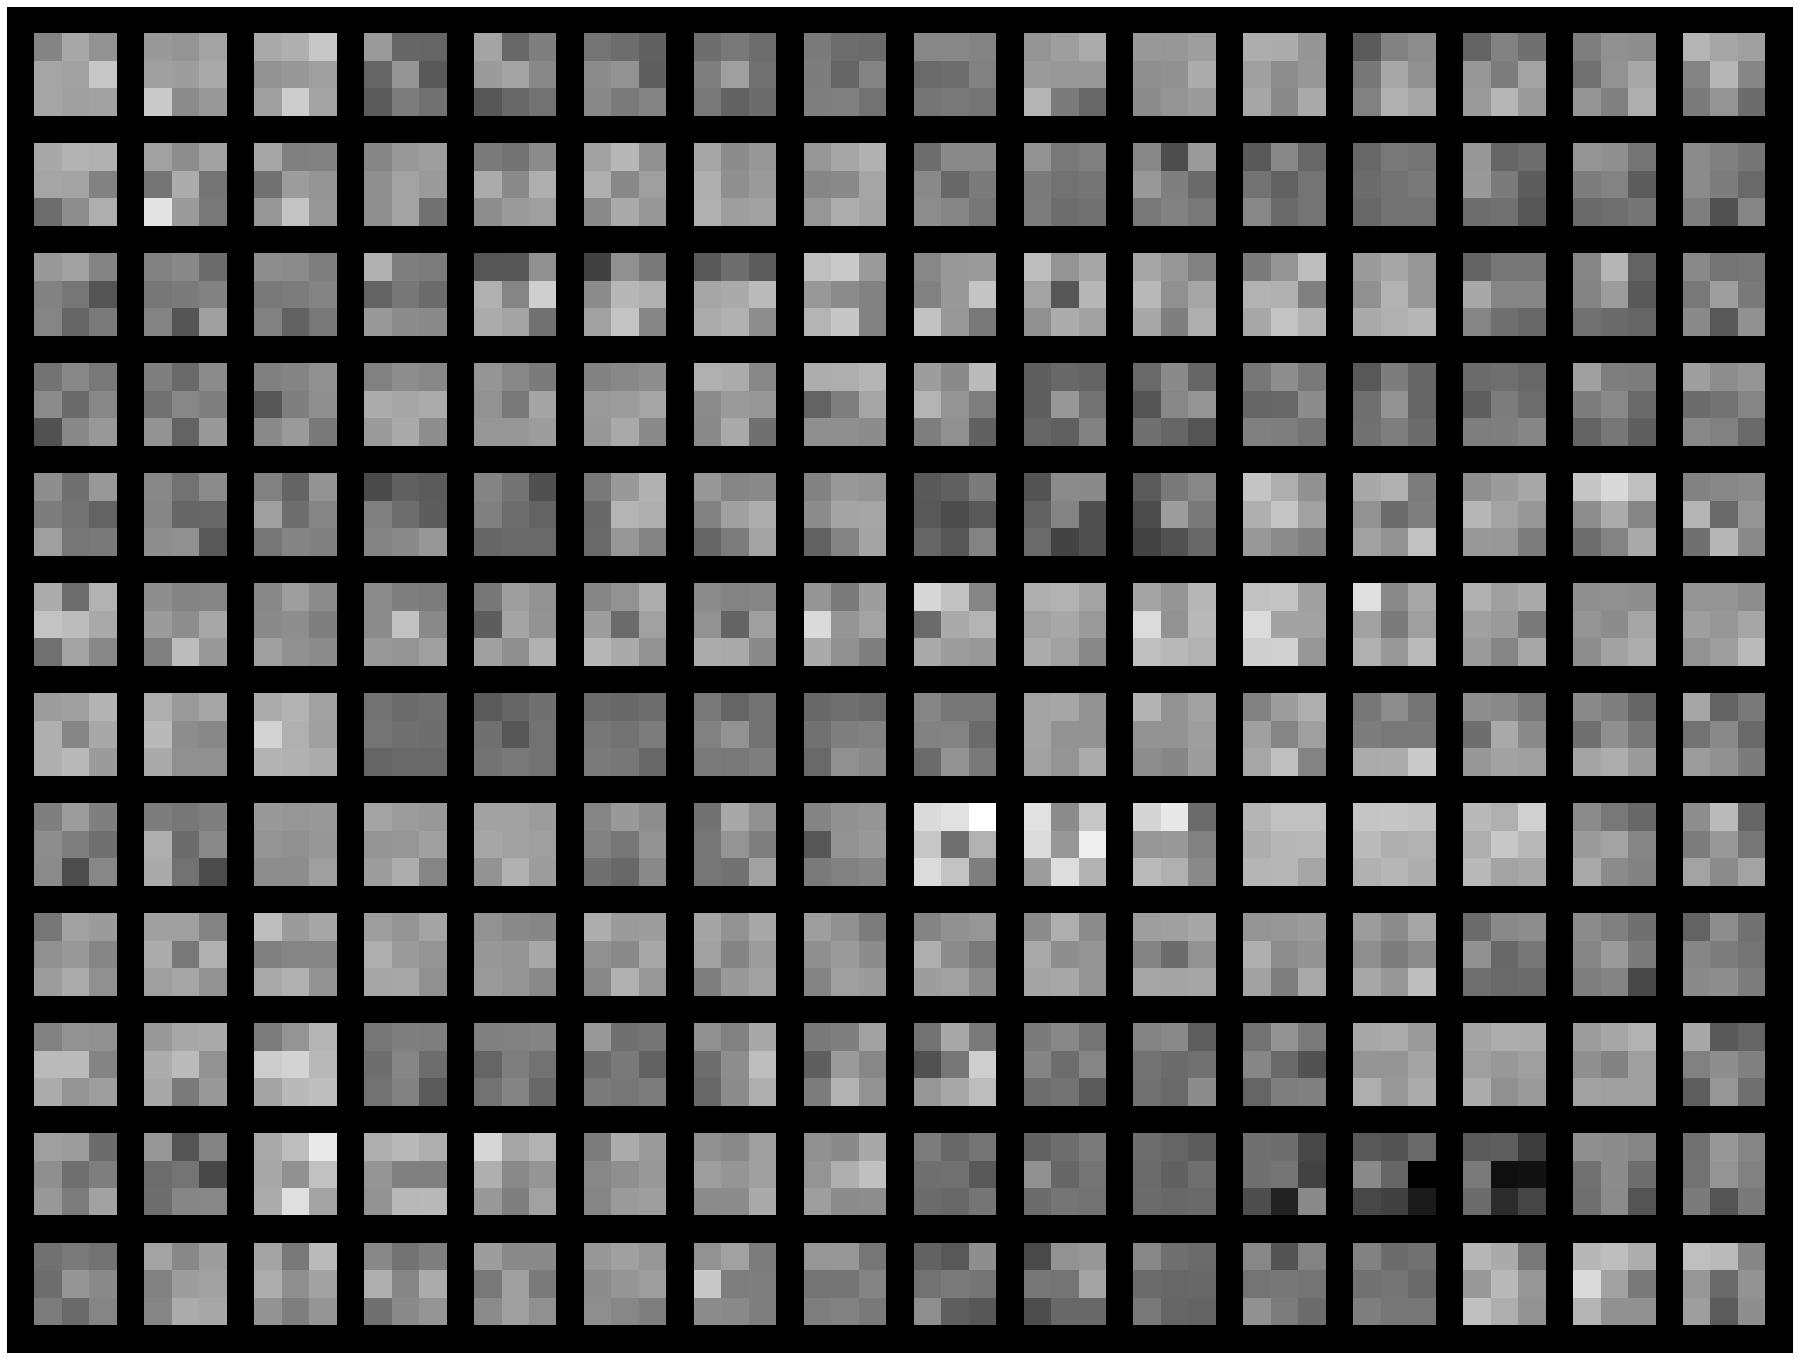

In [51]:
visTensor(weights_conv1, allkernels=True)
plt.axis('off')
plt.ioff()
plt.show()

In [52]:
weights_conv2_key = conv_keys[1]
weights_conv2 = weights_model[weights_conv2_key]

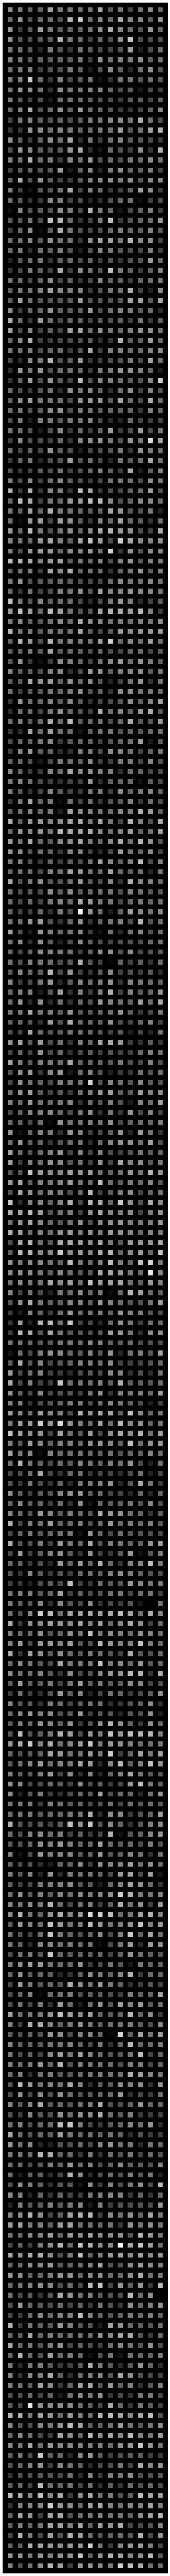

In [53]:
visTensor(weights_conv2, allkernels=True)
plt.axis('off')
plt.ioff()
plt.show()

In [76]:
weights_conv3_key = conv_keys[2]
weights_conv3 = weights_model[weights_conv3_key]

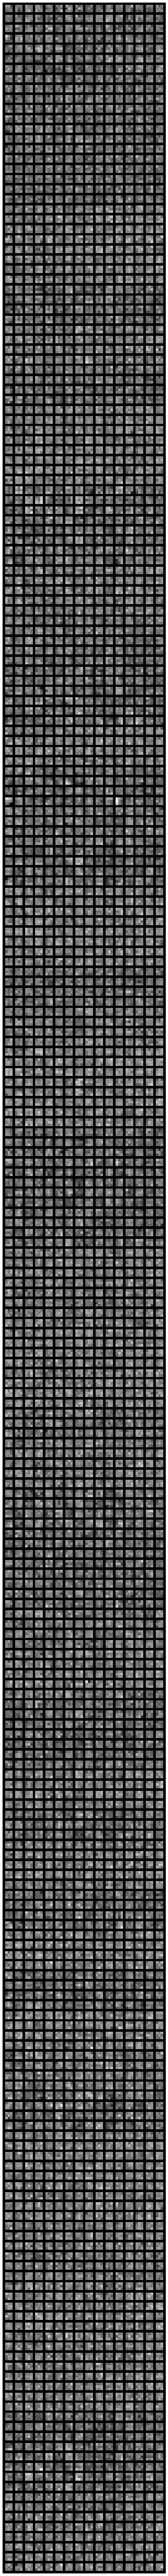

In [77]:
visTensor(weights_conv3, allkernels=True)
plt.axis('off')
plt.ioff()
plt.show()